In [ ]:
# original dataset
import numpy as np
import pandas as pd
import kagglehub

# Download latest version
path = kagglehub.dataset_download("miadul/heat-disease-predication-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heat-disease-predication-dataset' dataset.
Path to dataset files: /kaggle/input/heat-disease-predication-dataset


In [ ]:
import kagglehub

# Download latest version
path_2 = kagglehub.dataset_download("jayaantanaath/student-habits-vs-academic-performance")

print("Path to dataset files:", path_2)

Using Colab cache for faster access to the 'student-habits-vs-academic-performance' dataset.
Path to dataset files: /kaggle/input/student-habits-vs-academic-performance


In [ ]:
df = pd.read_csv("/kaggle/input/student-habits-vs-academic-performance/student_habits_performance.csv")

In [ ]:
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [ ]:
df = df.drop(columns=['student_id'])

In [ ]:
df.columns

Index(['age', 'gender', 'study_hours_per_day', 'social_media_hours',
       'netflix_hours', 'part_time_job', 'attendance_percentage',
       'sleep_hours', 'diet_quality', 'exercise_frequency',
       'parental_education_level', 'internet_quality', 'mental_health_rating',
       'extracurricular_participation', 'exam_score'],
      dtype='object')

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Original dataset
# TARGET_COLUMN = 'Heart_Disease'  # <--- REPLACE 'target' with your actual target column name (e.g., 'HeartDisease')
# CATEGORICAL_COLS = ['Gender', 'Smoking', 'Alcohol_Intake', 'Physical_Activity', 'Diet', 'Stress_Level']
# SCALAR_COLS = ['Age', 'Weight', 'Height', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Heart_Rate', 'Cholesterol_Total', 'Blood_Sugar_Fasting']

TARGET_COLUMN = 'exam_score'
CATEGORICAL_COLS = ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']
SCALAR_COLS = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']

if 'df' in locals():

    # set target column
    X = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]

    # data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Training rows: {X_train.shape[0]}")
    print(f"Testing rows: {X_test.shape[0]}")

    # scaling and inputing NaN values for categorical values with "unknown"
    # before one-hot encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, CATEGORICAL_COLS),
            ('num', numeric_transformer, SCALAR_COLS)
        ],
        remainder='passthrough' # Keeps other columns unchanged
    )

    # fitting scaler (only on training set to avoid leakage)
    X_train_processed = preprocessor.fit_transform(X_train)

    X_test_processed = preprocessor.transform(X_test)

    # model instantiation
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        eval_metric='rmse',
        use_label_encoder=False,
        random_state=42
    )

# Training loop
    print("Starting XGBoost training...")

    eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]

    model.fit(
        X_train_processed,
        y_train,
        eval_set=eval_set,
        verbose=False
    )

    print("Training Complete.")

"""
    # --- 9. Evaluation Loop ---
    y_pred = model.predict(X_test_processed)

    print("\n--- Model Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    new_cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_COLS)
    print("\nVerify Unknown columns (Example):")
    print([col for col in new_cat_features if 'Unknown' in col])

"""

print("Training Complete.")

y_pred = model.predict(X_test_processed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Regression Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-Squared Score (R2): {r2:.4f}")

Training rows: 800
Testing rows: 200
Starting XGBoost training...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:13:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Complete.
Training Complete.

--- Regression Model Evaluation ---
Root Mean Squared Error (RMSE): 5.5716
R-Squared Score (R2): 0.8789


In [ ]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test_processed)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Regression Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-Squared Score (R2): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


--- Regression Model Evaluation ---
Root Mean Squared Error (RMSE): 5.5716
R-Squared Score (R2): 0.8789
Mean Absolute Error (MAE): 4.6062


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_COLS)

    num_feature_names = SCALAR_COLS

    all_feature_names = np.concatenate([cat_feature_names, num_feature_names])

except Exception as e:
    print(f"Error extracting feature names: {e}")
    all_feature_names = [f'Feature_{i}' for i in range(X_train_processed.shape[1])]

feature_scores = pd.Series(model.feature_importances_, index=all_feature_names).sort_values(ascending=False)

print("\n--- Top 10 Feature Importance Scores ---")
print(feature_scores.head(10))


--- Top 10 Feature Importance Scores ---
study_hours_per_day                 0.557462
mental_health_rating                0.134714
exercise_frequency                  0.053344
social_media_hours                  0.051085
netflix_hours                       0.045194
sleep_hours                         0.041429
attendance_percentage               0.019451
extracurricular_participation_No    0.010636
gender_Male                         0.009696
diet_quality_Good                   0.008425
dtype: float32


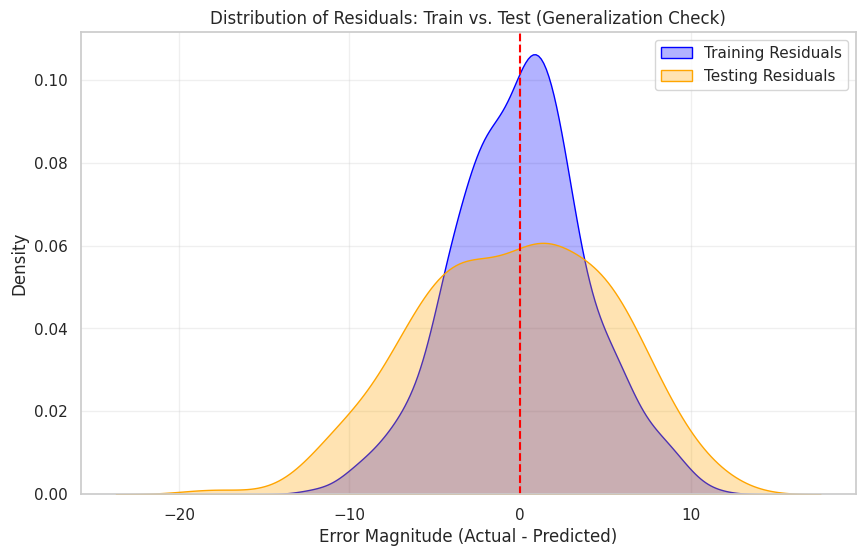

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_pred = model.predict(X_train_processed)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_pred

plt.figure(figsize=(10, 6))

sns.kdeplot(train_residuals, fill=True, label='Training Residuals', color='blue', alpha=0.3)

sns.kdeplot(test_residuals, fill=True, label='Testing Residuals', color='orange', alpha=0.3)

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Error Magnitude (Actual - Predicted)')
plt.ylabel('Density')
plt.title('Distribution of Residuals: Train vs. Test (Generalization Check)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-2943603737.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_data = results_df.groupby('Score_Range')['Squared_Error'].mean()
/tmp/ipython-input-2943603737.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


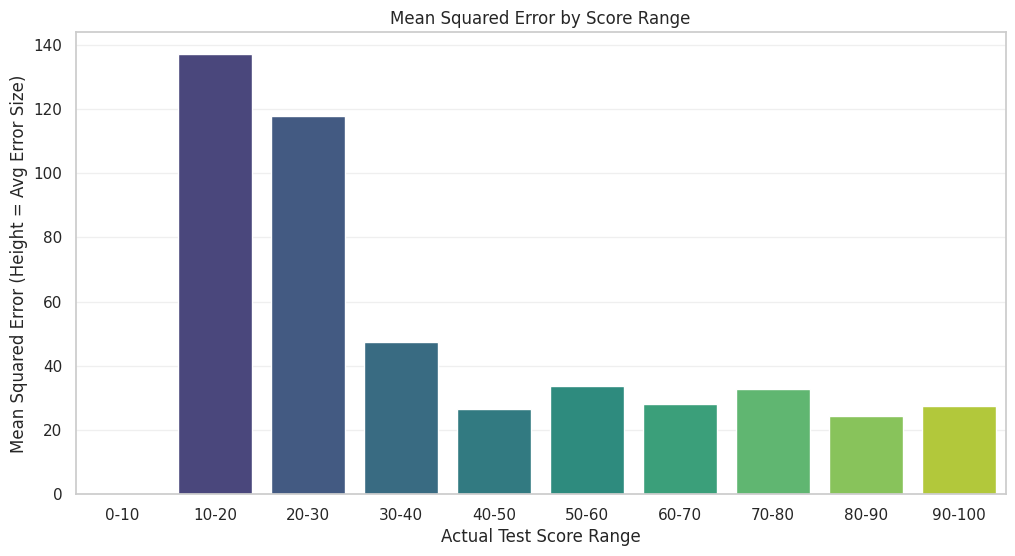

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Create 10-point bins
bins = range(0, 101, 10)
labels = [f'{i}-{i+10}' for i in range(0, 100, 10)]
results_df['Score_Range'] = pd.cut(results_df['Actual'], bins=bins, labels=labels, right=False)

# Calculate Squared Error
results_df['Squared_Error'] = (results_df['Actual'] - results_df['Predicted']) ** 2

# Group by range and get the MEAN error
mse_data = results_df.groupby('Score_Range')['Squared_Error'].mean()


plt.figure(figsize=(12, 6))

sns.barplot(
    x=mse_data.index,
    y=mse_data.values,
    palette='viridis'
)

plt.title('Mean Squared Error by Score Range')
plt.xlabel('Actual Test Score Range')
plt.ylabel('Mean Squared Error (Height = Avg Error Size)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

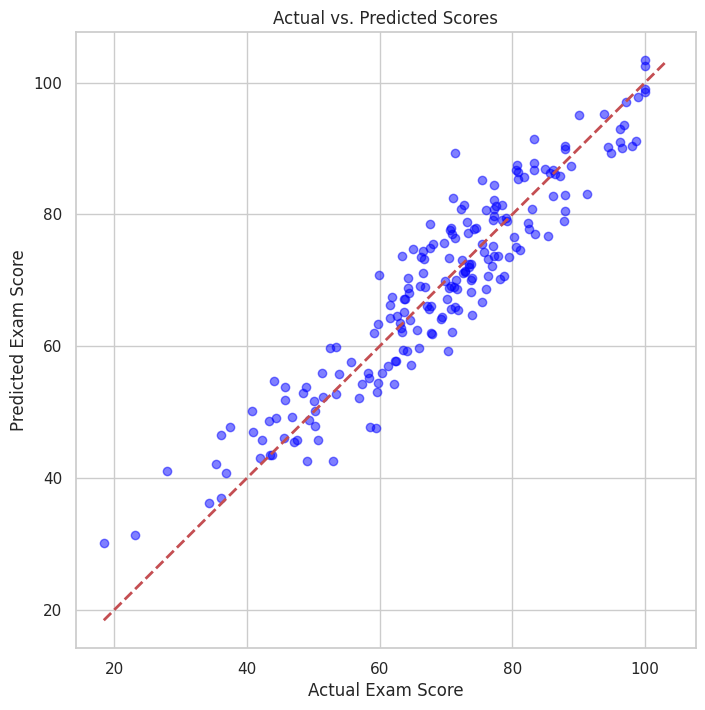

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')

# Draw the perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('Actual vs. Predicted Scores')
plt.grid(True)
plt.show()